# Time series analysis of the data lakes

In [1]:
import glob
import json
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import import_lakes
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import ARDRegression, BayesianRidge, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import torch


/home/mlehner/anaconda3/envs/sff_19/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Lac Leman

In [2]:
#df = import_lakes.import_lake()
df = import_lakes.import_lake_LeXplore()
df.sort_values(by="M", inplace=True)

In [3]:
df["day"] = df["date"].apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))

In [4]:
len(df["day"].unique())

202

In [5]:
# create new dataframe with mean values for each day and make day a column
df_day = df.groupby("day").mean()
df_day.reset_index(inplace=True)

/tmp/ipykernel_450/1668653208.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_day = df.groupby("day").mean()


<Axes: xlabel='day'>

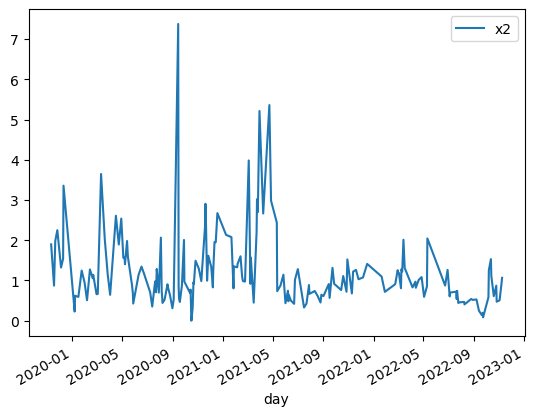

In [6]:
df_day.plot.line(x="day", y="x2")

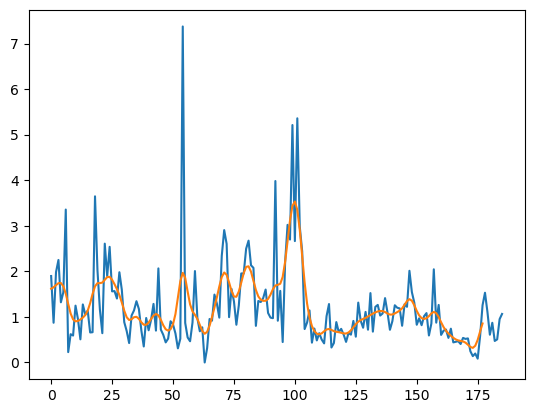

In [7]:
plt.plot(df_day['x2'].values)
plt.plot(gaussian_filter1d(df_day['x2'].values,2))

Text(0, 0.5, 'Temperature (°C)')

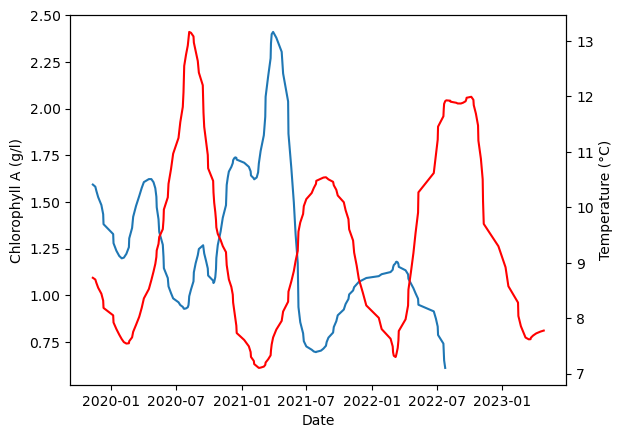

In [8]:
fig, ax = plt.subplots()
#ax.plot(df_day["day"], df_day["x2"], label="x2")
ax.plot(df_day["day"], gaussian_filter1d(df_day["x2"], 5), label="Chlorophyll A")
ax.set_ylabel("Chlorophyll A (g/l)")
ax.set_xlabel("Date")
# twin axis
ax2 = ax.twinx()
ax2.plot(df_day["day"], gaussian_filter1d(df_day["x"], 5), label="temperature", color="red")
ax2.set_ylabel("Temperature (°C)")


/tmp/ipykernel_450/738349656.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


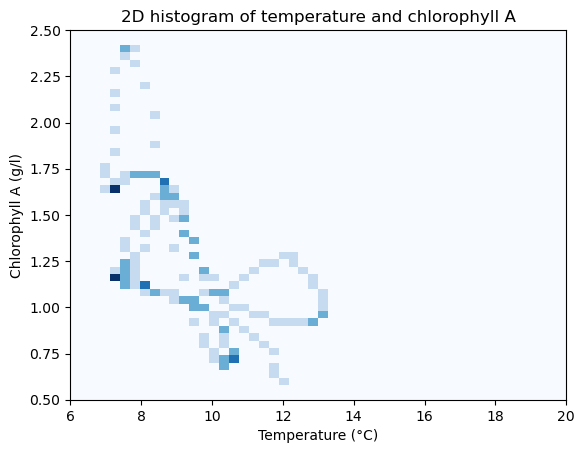

In [9]:
#2D histogram of x and x2
fig, ax = plt.subplots()
ax.hist2d(gaussian_filter1d(df_day["x"], 5), gaussian_filter1d(df_day["x2"], 5), bins=50, cmap="Blues", range=[[6,20],[0.5,2.5]])
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Chlorophyll A (g/l)")
ax.set_title("2D histogram of temperature and chlorophyll A")
fig.show()

## Zuger See

In [10]:
df_zug = import_lakes.import_lake_zug()
df_zug.sort_values(by="M", inplace=True)

In [11]:
len(df_zug["M"].unique())

79

In [12]:
df_zug["day"] = df_zug["date"].apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))
print(len(df_zug["day"].unique()))

5


<Axes: xlabel='date', ylabel='x2'>

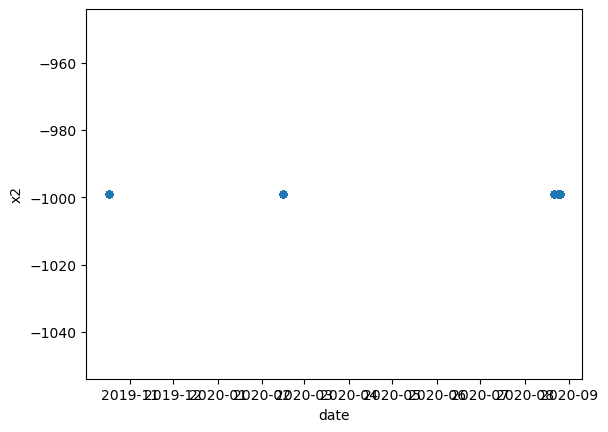

In [77]:
df_zug.plot.scatter(x="date", y="x2")

## Greifen see

In [2]:
df_g = import_lakes.import_lake_greifen()
df_g["day"] = df_g["date"].apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))
print(len(df_g))
print(len(df_g["day"].unique()))

6374
991


In [3]:
df_g_day = df_g.groupby("day").mean()
df_g_day.reset_index(inplace=True)

/tmp/ipykernel_560/818104055.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_g_day = df_g.groupby("day").mean()


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

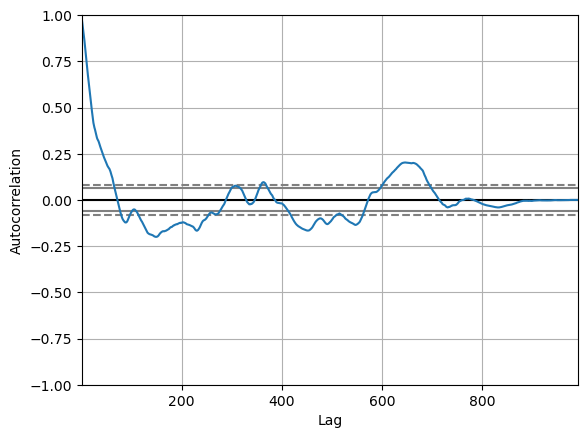

In [4]:
autocorrelation_plot(df_g_day["z6"])

In [5]:
# get autocorrelation of x2 as a function of lag
autocor_g_day = [df_g_day["z6"].autocorr(lag=i) for i in range(1, 365)]

In [6]:
#find last value above 0.5
for i in range(len(autocor_g_day)):
    if autocor_g_day[i] < 0.5:
        break
print(i)

20


In [7]:
df_g_day_gauss = df_g_day.copy()
df_g_day_gauss.dropna(inplace=True)
df_g_day_gauss["z1"] = gaussian_filter1d(df_g_day["z1"], 3)
df_g_day_gauss["z2"] = gaussian_filter1d(df_g_day["z2"], 3)
df_g_day_gauss["z3"] = gaussian_filter1d(df_g_day["z3"], 3)
df_g_day_gauss["z4"] = gaussian_filter1d(df_g_day["z4"], 3)
df_g_day_gauss["z5"] = gaussian_filter1d(df_g_day["z5"], 3)
df_g_day_gauss["z6"] = gaussian_filter1d(df_g_day["z6"], 3)
df_g_day_gauss["z7"] = gaussian_filter1d(df_g_day["z7"], 3)
df_g_day_gauss["z8"] = gaussian_filter1d(df_g_day["z8"], 3)
df_g_day_gauss["z9"] = gaussian_filter1d(df_g_day["z9"], 3)


In [8]:
df_g_day_gauss.columns

Index(['day', 'x', 'z', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9'], dtype='object')

/tmp/ipykernel_560/645696914.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


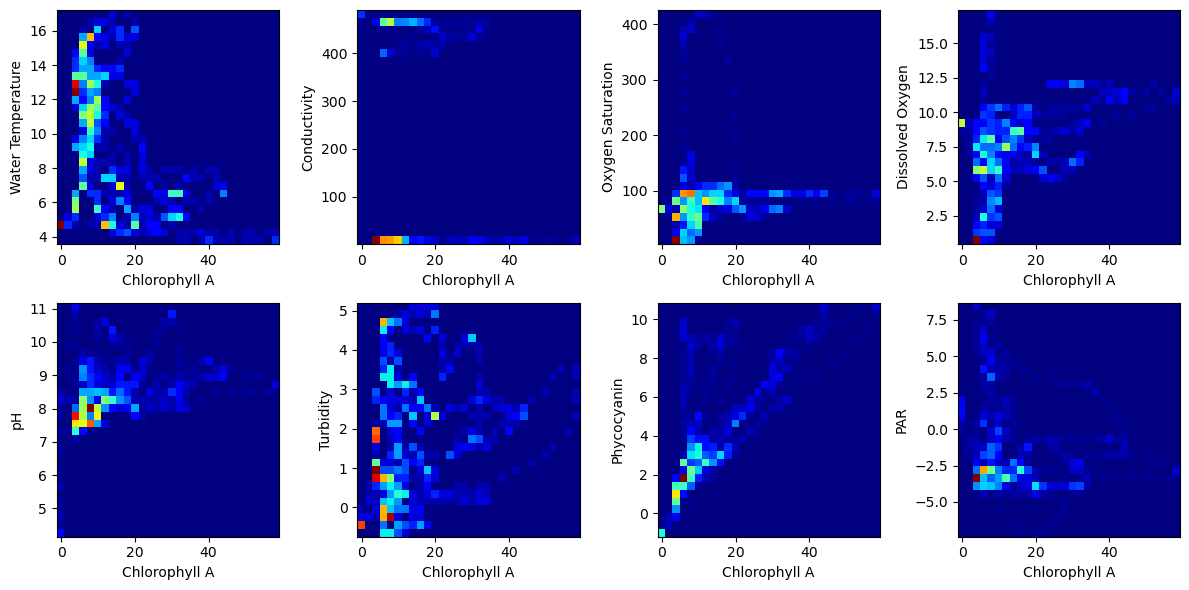

In [9]:
fig, ax, = plt.subplots(ncols=4, nrows=2, figsize=(12,6))
ax[0,0].hist2d(df_g_day_gauss["z6"], df_g_day_gauss["z"], bins=30, cmap="jet")
ax[0,0].set_xlabel("Chlorophyll A")
ax[0,0].set_ylabel("Water Temperature")
ax[0,1].hist2d(df_g_day_gauss["z6"], df_g_day_gauss["z2"], bins=30, cmap="jet")
ax[0,1].set_xlabel("Chlorophyll A")
ax[0,1].set_ylabel("Conductivity")
ax[0,2].hist2d(df_g_day_gauss["z6"], df_g_day_gauss["z3"], bins=30, cmap="jet")
ax[0,2].set_xlabel("Chlorophyll A")
ax[0,2].set_ylabel("Oxygen Saturation")
ax[0,3].hist2d(df_g_day_gauss["z6"], df_g_day_gauss["z4"], bins=30, cmap="jet")
ax[0,3].set_xlabel("Chlorophyll A")
ax[0,3].set_ylabel("Dissolved Oxygen")
ax[1,0].hist2d(df_g_day_gauss["z6"], df_g_day_gauss["z5"], bins=30, cmap="jet")
ax[1,0].set_xlabel("Chlorophyll A")
ax[1,0].set_ylabel("pH")
ax[1,1].hist2d(df_g_day_gauss["z6"], df_g_day_gauss["z7"], bins=30, cmap="jet")
ax[1,1].set_xlabel("Chlorophyll A")
ax[1,1].set_ylabel("Turbidity")
ax[1,2].hist2d(df_g_day_gauss["z6"], df_g_day_gauss["z8"], bins=30, cmap="jet")
ax[1,2].set_xlabel("Chlorophyll A")
ax[1,2].set_ylabel("Phycocyanin")
ax[1,3].hist2d(df_g_day_gauss["z6"], df_g_day_gauss["z9"], bins=30, cmap="jet")
ax[1,3].set_xlabel("Chlorophyll A")
ax[1,3].set_ylabel("PAR")
fig.tight_layout()
fig.show()

/tmp/ipykernel_560/497669262.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


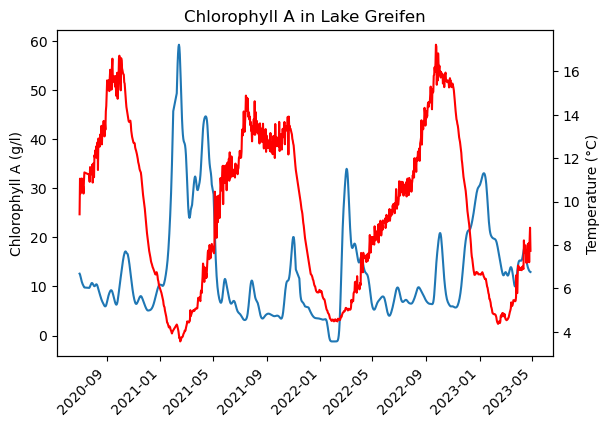

In [10]:
fig, ax = plt.subplots()
ax.plot(df_g_day_gauss["day"], df_g_day_gauss["z6"], label="Chlorophyll A")
ax.set_ylabel("Chlorophyll A (g/l)")
# x label date in 45° angle
fig.autofmt_xdate(rotation=45)
ax.set_title("Chlorophyll A in Lake Greifen")
# twin axis
twin1 = ax.twinx()
twin1.plot(df_g_day_gauss["day"], df_g_day_gauss["z"], label="temperature", color="red")
twin1.set_ylabel("Temperature (°C)")
fig.show()

In [11]:
#fourier spectrum of chlorophyll A
z6_fft = np.fft.fft(df_g_day_gauss["z6"])
z6_fft = np.fft.fftshift(z6_fft)
z6_fft = np.abs(z6_fft)
z6_fft = z6_fft**2
z6_fft = z6_fft/len(z6_fft)
z6_fft = z6_fft[0:int(len(z6_fft)/2)]
z6_fft = z6_fft*2
z6_fft[0] = z6_fft[0]/2
z6_fft = 10*np.log10(z6_fft)
z6_fft = pd.DataFrame(z6_fft)
z6_fft.columns = ["z6_fft"]
z6_fft["freq"] = np.linspace(0, 1, len(z6_fft))
z6_fft["freq"] = z6_fft["freq"]*365
z6_fft["freq"] = z6_fft["freq"]-365/2
z6_fft["freq"] = z6_fft["freq"].apply(lambda x: x if x>0 else x+365)
z6_fft["freq"] = z6_fft["freq"].apply(lambda x: x if x<365 else x-365)
z6_fft.sort_values(by="freq", inplace=True)
z6_fft.reset_index(inplace=True, drop=True)

/tmp/ipykernel_560/1051159919.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


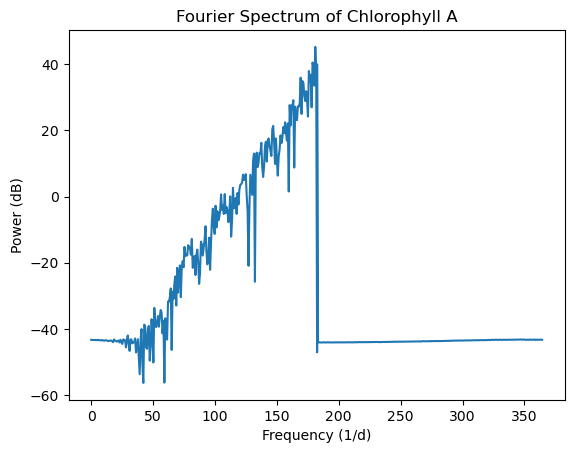

In [12]:
fig, ax = plt.subplots()
ax.plot(z6_fft["freq"], z6_fft["z6_fft"])
ax.set_xlabel("Frequency (1/d)")
ax.set_ylabel("Power (dB)")
ax.set_title("Fourier Spectrum of Chlorophyll A")
fig.show()

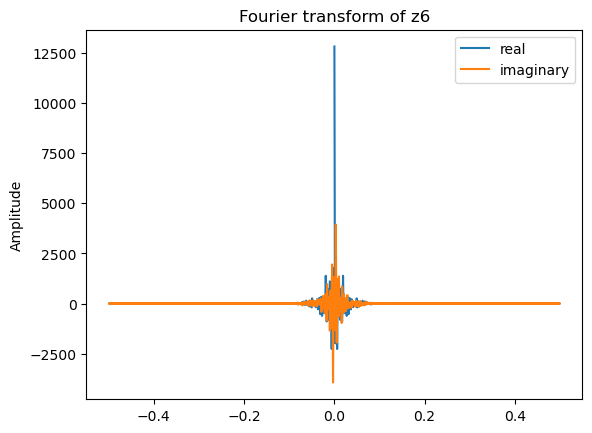

In [13]:
# fourier transform of z6
z6_fft = np.fft.fft(df_g_day_gauss['z6'].values)
z6_fft_freq = np.fft.fftfreq(len(z6_fft), d=1)
plt.plot(z6_fft_freq, z6_fft.real, z6_fft_freq, z6_fft.imag)
plt.title("Fourier transform of z6")
plt.ylabel("Amplitude")
plt.legend(["real","imaginary"])
plt.show()

# Regression analysis of the data lakes

In [58]:
z6data = df_g_day_gauss['z6'].values

In [59]:
train_z6 = z6data[:600]
n_steps = 6
X_train, Y_train = [], []
for i in range(n_steps, len(train_z6)-6):
    X_train.append(train_z6[i-n_steps:i])
    Y_train.append(train_z6[i+6])

test_z6 = z6data[600:]
X_test, Y_test = [], []
for i in range(n_steps, len(test_z6)-6):
    X_test.append(test_z6[i-n_steps:i])
    Y_test.append(test_z6[i+6])

In [60]:
ridgeRegression = Ridge()
lassoRegression = Lasso()
ardRegression = ARDRegression()
bayRegression = BayesianRidge()
ridgeRegression.fit(X_train, Y_train)
lassoRegression.fit(X_train, Y_train)
ardRegression.fit(X_train, Y_train)
bayRegression.fit(X_train, Y_train)
prediction_ridgeRegression = ridgeRegression.predict(X_train)
prediction_lassoRegression = lassoRegression.predict(X_train)
prediction_ardRegression = ardRegression.predict(X_train)
prediction_bayRegression = bayRegression.predict(X_train)

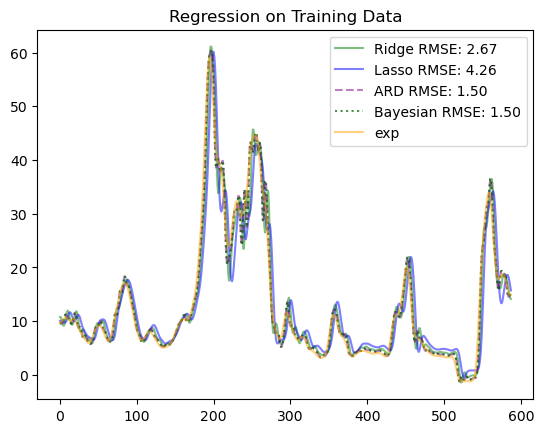

In [61]:
plt.plot(prediction_ridgeRegression, color='green', alpha=0.5,label=f"Ridge RMSE: {np.sqrt(mean_squared_error(Y_train, prediction_ridgeRegression)):.2f}")
plt.plot(prediction_lassoRegression, color='blue', alpha=0.5, label=f"Lasso RMSE: {np.sqrt(mean_squared_error(Y_train, prediction_lassoRegression)):.2f}")
plt.plot(prediction_ardRegression, color='purple', alpha=0.5, linestyle='--', label=f"ARD RMSE: {np.sqrt(mean_squared_error(Y_train, prediction_ardRegression)):.2f}")
plt.plot(prediction_bayRegression, color='darkgreen', alpha=0.7, linestyle=':', label=f"Bayesian RMSE: {np.sqrt(mean_squared_error(Y_train, prediction_bayRegression)):.2f}")
plt.plot(np.array(Y_train).tolist(),label='exp', color='orange', alpha=0.5)
#plt.plot([0 for i in range(7)]+[y for y in np.array(Y_train).tolist()],label='7 day pre')
plt.legend()
plt.title("Regression on Training Data")
plt.show()

/tmp/ipykernel_560/1142735454.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


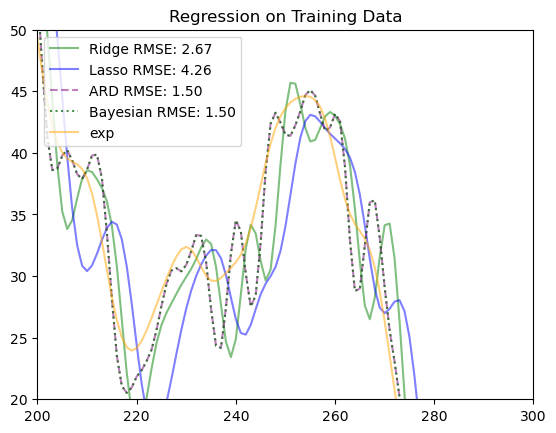

In [62]:
# inset region [[200,300], [20,50]]
fig, ax = plt.subplots()
ax.plot(prediction_ridgeRegression, color='green', alpha=0.5, label=f"Ridge RMSE: {np.sqrt(mean_squared_error(Y_train, prediction_ridgeRegression)):.2f}")
ax.plot(prediction_lassoRegression, color='blue', alpha=0.5, label=f"Lasso RMSE: {np.sqrt(mean_squared_error(Y_train, prediction_lassoRegression)):.2f}")
ax.plot(prediction_ardRegression, color='purple', alpha=0.5, linestyle='--', label=f"ARD RMSE: {np.sqrt(mean_squared_error(Y_train, prediction_ardRegression)):.2f}")
ax.plot(prediction_bayRegression, color='darkgreen', alpha=0.7, linestyle=':', label=f"Bayesian RMSE: {np.sqrt(mean_squared_error(Y_train, prediction_bayRegression)):.2f}")
ax.plot(np.array(Y_train).tolist(),label='exp', color='orange', alpha=0.5)
ax.set_title("Regression on Training Data")
ax.set_xlim(200,300)
ax.set_ylim(20,50)
ax.legend()
fig.show()

In [63]:
predictions_test_ard = ardRegression.predict(X_test)
predictions_test_bay = bayRegression.predict(X_test)
predictions_test_ridge = ridgeRegression.predict(X_test)
predictions_test_lasso = lassoRegression.predict(X_test)

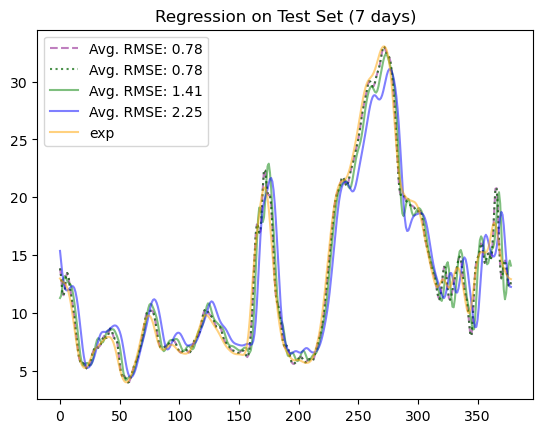

In [64]:
plt.plot(predictions_test_ard, color='purple', alpha=0.5, linestyle='--',label=f"Avg. RMSE: {round(np.sqrt(mean_squared_error(Y_test, predictions_test_ard)),2)}")
plt.plot(predictions_test_bay, color='darkgreen', alpha=0.7, linestyle=':', label=f"Avg. RMSE: {round(np.sqrt(mean_squared_error(Y_test, predictions_test_bay)),2)}")
plt.plot(predictions_test_ridge, color='green', alpha=0.5, label=f"Avg. RMSE: {round(np.sqrt(mean_squared_error(Y_test, predictions_test_ridge)),2)}")
plt.plot(predictions_test_lasso, color='blue', alpha=0.5, label=f"Avg. RMSE: {round(np.sqrt(mean_squared_error(Y_test, predictions_test_lasso)),2)}")
plt.plot(np.array(Y_test).tolist(),label='exp', color='orange', alpha=0.5)
#plt.plot([0 for i in range(7)]+[y for y in np.array(Y_test).tolist()],label='7 day pre')
plt.legend()
plt.title("Regression on Test Set (7 days)")
plt.show()

In [65]:
# Calculate RMSE
rmse_ard = np.sqrt(mean_squared_error(Y_test, predictions_test_ard))
rmse_bay = np.sqrt(mean_squared_error(Y_test, predictions_test_bay))
rmse_ridge = np.sqrt(mean_squared_error(Y_test, predictions_test_ridge))
rmse_lasso = np.sqrt(mean_squared_error(Y_test, predictions_test_lasso))
print(f"RMSE ard: {rmse_ard:.4f}, RMSE bay: {rmse_bay:.4f}, RMSE ridge: {rmse_ridge:.4f}, RMSE lasso: {rmse_lasso:.4f}")

RMSE ard: 0.7814, RMSE bay: 0.7814, RMSE ridge: 1.4111, RMSE lasso: 2.2485


## Use pH (z5), Oxigen (z3)and temperature (z)

In [66]:
z6data = gaussian_filter1d(df_g_day['z6'].values,4)
z5data = gaussian_filter1d(df_g_day['z5'].values,4)
z3data = gaussian_filter1d(df_g_day['z3'].values,4)
z_data = gaussian_filter1d(df_g_day['z'].values,4)

In [67]:
X_train, Y_train = [], []
X_test, Y_test = [], []
n_steps = 6
split = 600
for i in range(n_steps, split-6):
    X_train.append([z6data[i-n_steps:i],z5data[i-n_steps:i],z3data[i-n_steps:i], z_data[i-n_steps:i]])
    Y_train.append(z6data[i+6])
for i in range(split, len(z6data)-6):
    X_test.append([z6data[i-n_steps:i],z5data[i-n_steps:i],z3data[i-n_steps:i], z_data[i-n_steps:i]])
    Y_test.append(z6data[i+6])

In [68]:
print(len(X_train), len(Y_train), len(X_test), len(Y_test))

588 588 385 385


In [69]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [70]:
# flatten last two dimensions
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

In [71]:
ridgeRegression = Ridge()
lassoRegression = Lasso()
ardRegression = ARDRegression()
bayRegression = BayesianRidge()
ridgeRegression.fit(X_train, Y_train)
lassoRegression.fit(X_train, Y_train)
ardRegression.fit(X_train, Y_train)
bayRegression.fit(X_train, Y_train)
prediction_ridgeRegression = ridgeRegression.predict(X_train)
prediction_lassoRegression = lassoRegression.predict(X_train)
prediction_ardRegression = ardRegression.predict(X_train)
prediction_bayRegression = bayRegression.predict(X_train)

Text(0.5, 1.0, 'Regression on Train Set (Temperature, Oxygen, pH included)')

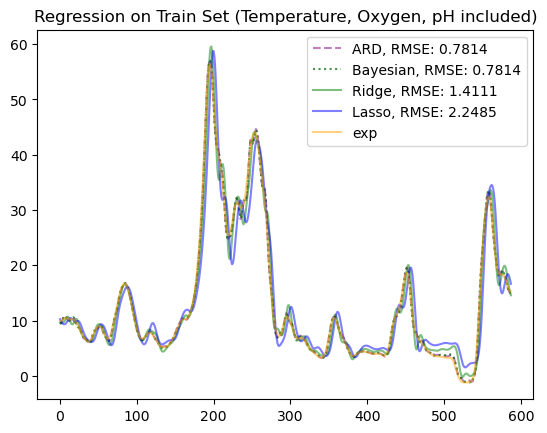

In [72]:
plt.plot(prediction_ardRegression, color='purple', alpha=0.5, linestyle='--',label=f"ARD, RMSE: {rmse_ard:.4f}")
plt.plot(prediction_bayRegression, color='darkgreen', alpha=0.7, linestyle=':', label=f"Bayesian, RMSE: {rmse_bay:.4f}")
plt.plot(prediction_ridgeRegression, color='green', alpha=0.5, label=f"Ridge, RMSE: {rmse_ridge:.4f}")
plt.plot(prediction_lassoRegression, color='blue', alpha=0.5, label=f"Lasso, RMSE: {rmse_lasso:.4f}")
plt.plot(np.array(Y_train).tolist(),label='exp', color='orange', alpha=0.5)
#plt.plot([0 for i in range(7)]+[y for y in np.array(Y_train).tolist()],label='7 day pre')
plt.legend()
plt.title('Regression on Train Set (Temperature, Oxygen, pH included)')

In [73]:
predictions_test_ard = ardRegression.predict(X_test)
predictions_test_bay = bayRegression.predict(X_test)
predictions_test_ridge = ridgeRegression.predict(X_test)
predictions_test_lasso = lassoRegression.predict(X_test)
rmse_ard_test = np.sqrt(mean_squared_error(Y_test, predictions_test_ard))
rmse_bay_test = np.sqrt(mean_squared_error(Y_test, predictions_test_bay))
rmse_ridge_test = np.sqrt(mean_squared_error(Y_test, predictions_test_ridge))
rmse_lasso_test = np.sqrt(mean_squared_error(Y_test, predictions_test_lasso))

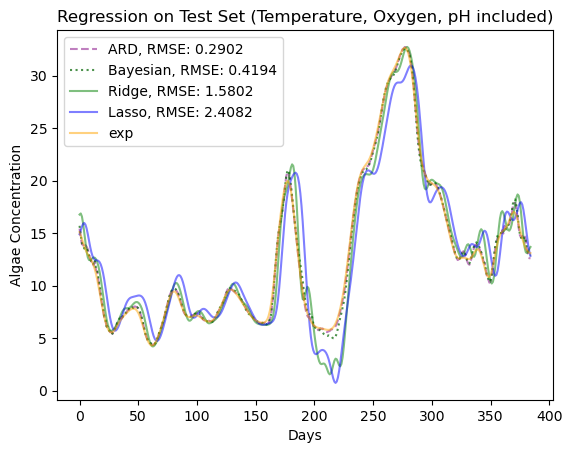

In [76]:

fig, ax = plt.subplots()
ax.plot(predictions_test_ard, color='purple', alpha=0.5, linestyle='--',label=f"ARD, RMSE: {rmse_ard_test:.4f}")
ax.plot(predictions_test_bay, color='darkgreen', alpha=0.7, linestyle=':', label=f"Bayesian, RMSE: {rmse_bay_test:.4f}")
ax.plot(predictions_test_ridge, color='green', alpha=0.5, label=f"Ridge, RMSE: {rmse_ridge_test:.4f}")
ax.plot(predictions_test_lasso, color='blue', alpha=0.5, label=f"Lasso, RMSE: {rmse_lasso_test:.4f}")
ax.plot(np.array(Y_test).tolist(),label='exp', color='orange', alpha=0.5)
#ax.plot([0 for i in range(7)]+[y for y in np.array(Y_test).tolist()],label='7 day pre')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Algae Concentration')
plt.title('Regression on Test Set (Temperature, Oxygen, pH included)')
plt.show()

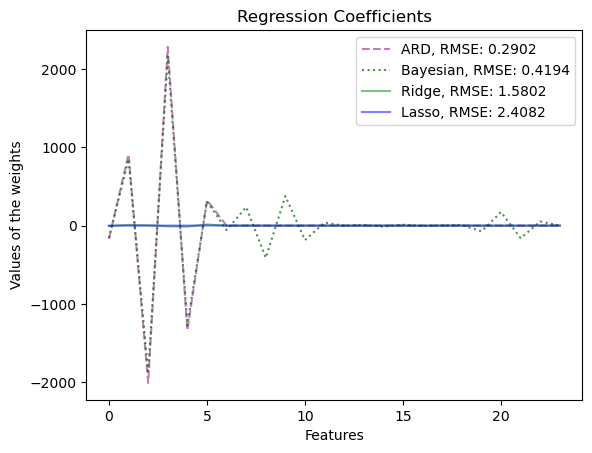

In [81]:
fig, ax = plt.subplots()
ax.plot(ardRegression.coef_, color='purple', alpha=0.5, linestyle='--',label=f"ARD, RMSE: {rmse_ard_test:.4f}")
ax.plot(bayRegression.coef_, color='darkgreen', alpha=0.7, linestyle=':', label=f"Bayesian, RMSE: {rmse_bay_test:.4f}")
ax.plot(ridgeRegression.coef_, color='green', alpha=0.5, label=f"Ridge, RMSE: {rmse_ridge_test:.4f}")
ax.plot(lassoRegression.coef_, color='blue', alpha=0.5, label=f"Lasso, RMSE: {rmse_lasso_test:.4f}")
#ax.set_yscale('log')
ax.set_xlabel('Features')
ax.set_ylabel('Values of the weights')
ax.legend()
plt.title('Regression Coefficients')
plt.show()

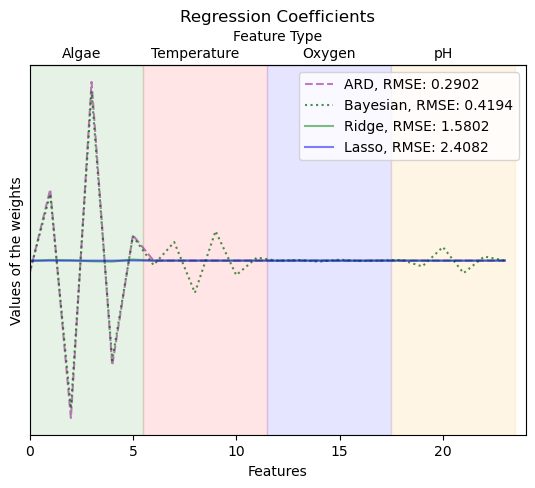

In [99]:
fig, ax = plt.subplots()
ax.plot(ardRegression.coef_, color='purple', alpha=0.5, linestyle='--',label=f"ARD, RMSE: {rmse_ard_test:.4f}")
ax.plot(bayRegression.coef_, color='darkgreen', alpha=0.7, linestyle=':', label=f"Bayesian, RMSE: {rmse_bay_test:.4f}")
ax.plot(ridgeRegression.coef_, color='green', alpha=0.5, label=f"Ridge, RMSE: {rmse_ridge_test:.4f}")
ax.plot(lassoRegression.coef_, color='blue', alpha=0.5, label=f"Lasso, RMSE: {rmse_lasso_test:.4f}")
#ax.set_yscale('log')
ax.set_xlabel('Features')
ax.set_ylabel('Values of the weights')
ax.set_xlim(0,24)
ax.legend()
plt.title('Regression Coefficients')
# show different feature regions (0-5 Algae, 6-11 Temperature, 12-17 Oxygen, 17-23 pH), extended above and labeled above
ax.axvspan(0, 5.5, alpha=0.1, color='green')
ax.axvspan(5.5, 11.5, alpha=0.1, color='red')
ax.axvspan(11.5, 17.5, alpha=0.1, color='blue')
ax.axvspan(17.5, 23.5, alpha=0.1, color='orange')
new_ax = ax.twiny()
new_ax.set_xticks([2.5, 8, 14.5, 20])
new_ax.set_xticklabels(['Algae', 'Temperature', 'Oxygen', 'pH'])
new_ax.set_xlabel('Feature Type')
new_ax.set_xlim(ax.get_xlim())
new_ax.set_ylim(ax.get_ylim())
new_ax.grid(False)
new_ax.set_frame_on(True)
new_ax.patch.set_visible(False)
new_ax.xaxis.set_ticks_position('top')
new_ax.xaxis.set_label_position('top')
new_ax.spines['top'].set_visible(True)
new_ax.spines['bottom'].set_visible(False)
new_ax.spines['left'].set_visible(False)
new_ax.spines['right'].set_visible(False)
new_ax.tick_params(axis='x', which='both', length=0)
new_ax.set_yticks([])
new_ax.set_yticklabels([])
new_ax.set_ylabel('')

plt.show()

In [84]:
ardRegression.coef_.shape

(24,)

In [85]:
X_train.shape

(588, 24)

Text(0.5, 0, 'Features')

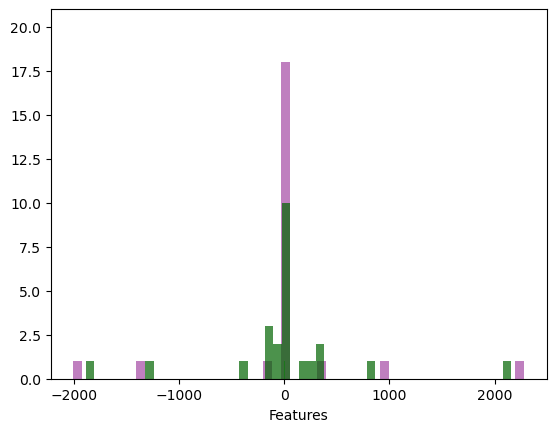

In [82]:
# histogram of the weights
fig, ax = plt.subplots()
ax.hist(ardRegression.coef_, bins=50, color='purple', alpha=0.5, label=f"ARD, RMSE: {rmse_ard_test:.4f}")
ax.hist(bayRegression.coef_, bins=50, color='darkgreen', alpha=0.7, label=f"Bayesian, RMSE: {rmse_bay_test:.4f}")
ax.hist(ridgeRegression.coef_, bins=50, color='green', alpha=0.5, label=f"Ridge, RMSE: {rmse_ridge_test:.4f}")
ax.hist(lassoRegression.coef_, bins=50, color='blue', alpha=0.5, label=f"Lasso, RMSE: {rmse_lasso_test:.4f}")
ax.set_xlabel('Features')


In [ ]:
plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
plt.plot(clf.coef_, color="darkblue", linestyle="-", linewidth=2, label="ARD estimate")
plt.plot(
    ols.coef_, color="yellowgreen", linestyle=":", linewidth=2, label="OLS estimate"
)

In [75]:
# rmse for test
rmse_ard = np.sqrt(mean_squared_error(Y_test, predictions_test_ard))
rmse_bay = np.sqrt(mean_squared_error(Y_test, predictions_test_bay))
print('Test RMSE ard: %.3f' % rmse_ard)
print('Test RMSE bay: %.3f' % rmse_bay)

Test RMSE ard: 0.290
Test RMSE bay: 0.419


In [39]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_MLP = scaler.transform(X_train)
X_test_MLP = scaler.transform(X_test)
mlp = MLPRegressor(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                        solver='sgd', verbose=0,  random_state=42,tol=1e-10)
mlp.fit(X_train_MLP,Y_train)
predictions_test_mlp = mlp.predict(X_test_MLP)

In [40]:
print('Test RMSE mlp: %.3f' % np.sqrt(mean_squared_error(Y_test, predictions_test_mlp)))

Test RMSE mlp: 4.366


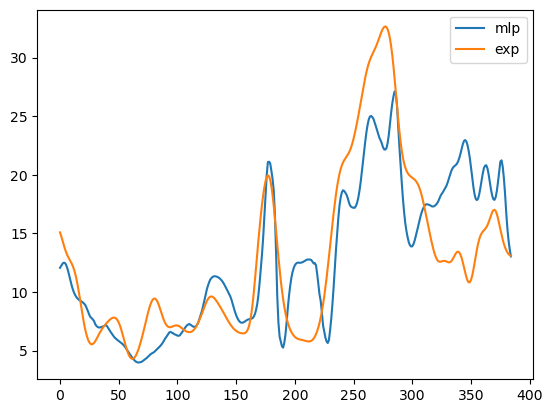

In [41]:
plt.plot(predictions_test_mlp,label="mlp")
plt.plot(np.array(Y_test).tolist(),label='exp')
plt.legend()

In [42]:
x_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(Y_train).float()
x_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(Y_test).float()

In [43]:
from torch import nn

/home/mlehner/anaconda3/envs/sff_19/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 192.66705322
epoch:  11 loss: 58.19590378
epoch:  21 loss: 30.22642136
epoch:  31 loss: 13.34106350
epoch:  41 loss: 2.71665764
epoch:  51 loss: 0.05258965
epoch:  61 loss: 3.87381387
epoch:  71 loss: 11.13728714
epoch:  81 loss: 12.60211563
epoch:  91 loss: 1.88347733
epoch: 101 loss: 0.86318082
epoch: 111 loss: 1.23271751
epoch: 121 loss: 0.60663044
epoch: 131 loss: 0.07458980
epoch: 141 loss: 0.05878050
epoch: 151 loss: 0.45097017
epoch: 161 loss: 0.85255998
epoch: 171 loss: 0.99124545
epoch: 181 loss: 0.80498773
epoch: 191 loss: 0.31608877
epoch: 201 loss: 0.00425600
epoch: 211 loss: 0.16154377
epoch: 221 loss: 0.57833987
epoch: 231 loss: 0.93185675
epoch: 241 loss: 0.97457850
epoch: 251 loss: 0.97347349
epoch: 261 loss: 0.96051687
epoch: 271 loss: 0.81473893
epoch: 281 loss: 0.71838367
epoch: 291 loss: 0.63702524
epoch: 301 loss: 0.59546334
epoch: 311 loss: 0.51460743
epoch: 321 loss: 0.45053604
epoch: 331 loss: 0.43215111
epoch: 341 loss: 0.28169787
epoch: 351 lo

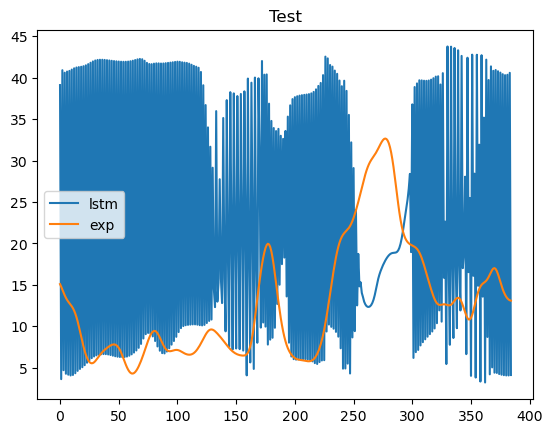

In [50]:
# LSTM model
rng_seed = 42
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq),1,-1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq),-1))
        return predictions[-1]
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
epochs = 500
for i in range(epochs):
    for seq, labels in zip(x_train_torch, y_train_torch):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
predictions_test_lstm = []
with torch.no_grad():
    for seq in x_test_torch:
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        predictions_test_lstm.append(model(seq).item())
print('Test RMSE lstm: %.3f' % np.sqrt(mean_squared_error(Y_test, predictions_test_lstm)))

fig, ax = plt.subplots()
ax.plot(predictions_test_lstm,label="lstm")
ax.plot(np.array(y_test_torch).tolist(),label='exp')
ax.legend()
plt.title('Test')
plt.show()

## Transversal analysis of the models

In [57]:
# test greifen ard model on lac leman data
df_day_noNan = df_day.dropna()
z6data_lac = gaussian_filter1d(df_day_noNan['x2'].values,4)
z5data_lac = gaussian_filter1d(df_day_noNan['x4'].values,4)
z3data_lac = gaussian_filter1d(df_day_noNan['x5'].values,4)
z_data_lac = gaussian_filter1d(df_day_noNan['x'].values,4)

In [60]:
X_lac, Y_lac = [], []
n_steps = 6
for i in range(n_steps, len(z6data_lac)-6):
    # if nan in data, skip
    X_lac.append([z6data_lac[i-n_steps:i],z5data_lac[i-n_steps:i],z3data_lac[i-n_steps:i], z_data_lac[i-n_steps:i]])
    Y_lac.append(z6data[i+6])
X_lac, Y_lac = np.array(X_lac), np.array(Y_lac)
X_lac = X_lac.reshape((X_lac.shape[0], X_lac.shape[1]*X_lac.shape[2]))
x_lac_torch = torch.from_numpy(X_lac).float()
y_lac_torch = torch.from_numpy(Y_lac).float()
x_lac_mlp = scaler.transform(X_lac)

In [61]:
# rmse of ard, bay, mlp, lstm on lac leman data
predictions_lac_ard = ardRegression.predict(X_lac)
predictions_lac_bay = bayRegression.predict(X_lac)
predictions_lac_mlp = mlp.predict(x_lac_mlp)
predictions_lac_lstm = []
with torch.no_grad():
    for seq in x_lac_torch:
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        predictions_lac_lstm.append(model(seq).item())

In [62]:
print('Test RMSE ard: %.3f' % np.sqrt(mean_squared_error(Y_lac, predictions_lac_ard)))
print('Test RMSE bay: %.3f' % np.sqrt(mean_squared_error(Y_lac, predictions_lac_bay)))
print('Test RMSE mlp: %.3f' % np.sqrt(mean_squared_error(Y_lac, predictions_lac_mlp)))
print('Test RMSE lstm: %.3f' % np.sqrt(mean_squared_error(Y_lac, predictions_lac_lstm)))

Test RMSE ard: 7.955
Test RMSE bay: 7.857
Test RMSE mlp: 8.019
Test RMSE lstm: 15.098


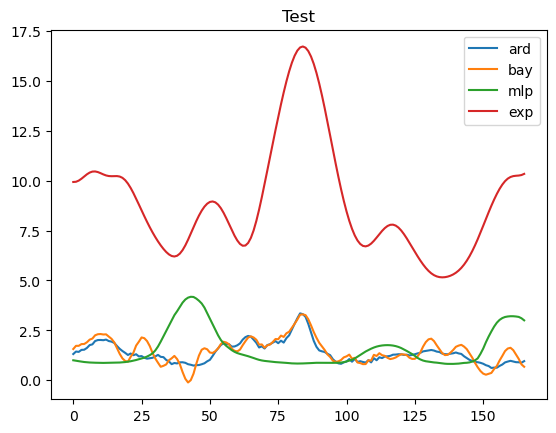

In [64]:
fig, ax = plt.subplots()
ax.plot(predictions_lac_ard,label="ard")
ax.plot(predictions_lac_bay,label="bay")
ax.plot(predictions_lac_mlp,label="mlp")
#ax.plot(predictions_lac_lstm,label="lstm")
ax.plot(Y_lac,label='exp')
ax.legend()
plt.title('Test')
plt.show()

Test RMSE ard: 2.025
Test RMSE bay: 1.564
Test RMSE mlp: 2.063


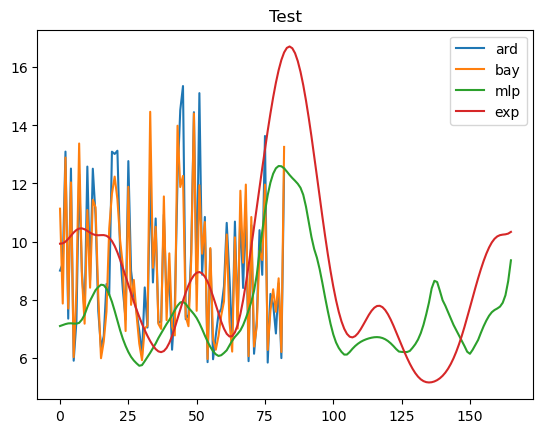

In [66]:
# transver learning on lac leman data
from sklearn.model_selection import train_test_split
# ard
X_lac_train, X_lac_test, Y_lac_train, Y_lac_test = train_test_split(X_lac, Y_lac, test_size=0.5, random_state=42)
ardRegression.fit(X_lac_train, Y_lac_train)
predictions_lac_ard = ardRegression.predict(X_lac_test)
print('Test RMSE ard: %.3f' % np.sqrt(mean_squared_error(Y_lac_test, predictions_lac_ard)))
# bay
bayRegression.fit(X_lac_train, Y_lac_train)
predictions_lac_bay = bayRegression.predict(X_lac_test)
print('Test RMSE bay: %.3f' % np.sqrt(mean_squared_error(Y_lac_test, predictions_lac_bay)))
# mlp
mlp.fit(x_lac_mlp, Y_lac)
predictions_lac_mlp = mlp.predict(x_lac_mlp)
print('Test RMSE mlp: %.3f' % np.sqrt(mean_squared_error(Y_lac, predictions_lac_mlp)))

fig, ax = plt.subplots()
ax.plot(predictions_lac_ard,label="ard")
ax.plot(predictions_lac_bay,label="bay")
ax.plot(predictions_lac_mlp,label="mlp")
ax.plot(Y_lac,label='exp')
ax.legend()
plt.title('Test')
plt.show()

Test RMSE ard: 633.234
Test RMSE bay: 462.837
Test RMSE mlp: 14.255


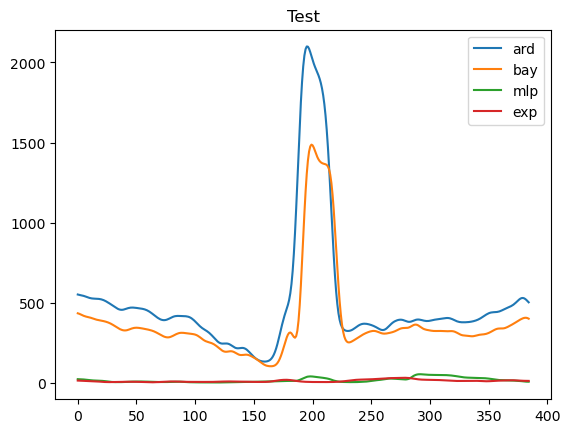

In [74]:
# reevaluate on greifen data
predictions_test_ard = ardRegression.predict(X_test)
predictions_test_bay = bayRegression.predict(X_test)
predictions_test_mlp = mlp.predict(X_test_MLP)

print('Test RMSE ard: %.3f' % np.sqrt(mean_squared_error(Y_test, predictions_test_ard)))
print('Test RMSE bay: %.3f' % np.sqrt(mean_squared_error(Y_test, predictions_test_bay)))
print('Test RMSE mlp: %.3f' % np.sqrt(mean_squared_error(Y_test, predictions_test_mlp)))

fig, ax = plt.subplots()
ax.plot(predictions_test_ard,label="ard")
ax.plot(predictions_test_bay,label="bay")
ax.plot(predictions_test_mlp,label="mlp")
ax.plot(np.array(y_test_torch).tolist(),label='exp')
ax.legend()
plt.title('Test')
plt.show()

In [67]:
# prepare data for zug data
df_zug_noNan = df_zug.dropna()
z6data_zug = gaussian_filter1d(df_zug_noNan['x2'].values,4)
z5data_zug = gaussian_filter1d(df_zug_noNan['x4'].values,4)
z3data_zug = gaussian_filter1d(df_zug_noNan['x5'].values,4)
z_data_zug = gaussian_filter1d(df_zug_noNan['x'].values,4)

In [70]:
# evaluate ard, bay, and mlp on zug data
X_zug, Y_zug = [], []
n_steps = 6
for i in range(n_steps, len(z6data_zug)-6):
    # if nan in data, skip
    X_zug.append([z6data_zug[i-n_steps:i],z5data_zug[i-n_steps:i],z3data_zug[i-n_steps:i], z_data_zug[i-n_steps:i]])
    Y_zug.append(z6data_zug[i+6])
X_zug, Y_zug = np.array(X_zug), np.array(Y_zug)
X_zug = X_zug.reshape((X_zug.shape[0], X_zug.shape[1]*X_zug.shape[2]))
x_zug_torch = torch.from_numpy(X_zug).float()
y_zug_torch = torch.from_numpy(Y_zug).float()
x_zug_mlp = scaler.transform(X_zug)

# rmse of ard, bay, mlp, lstm on zug data
predictions_zug_ard = ardRegression.predict(X_zug)
predictions_zug_bay = bayRegression.predict(X_zug)
predictions_zug_mlp = mlp.predict(x_zug_mlp)

Test RMSE ard: 4993.032
Test RMSE bay: 5485.538
Test RMSE mlp: 16646.977


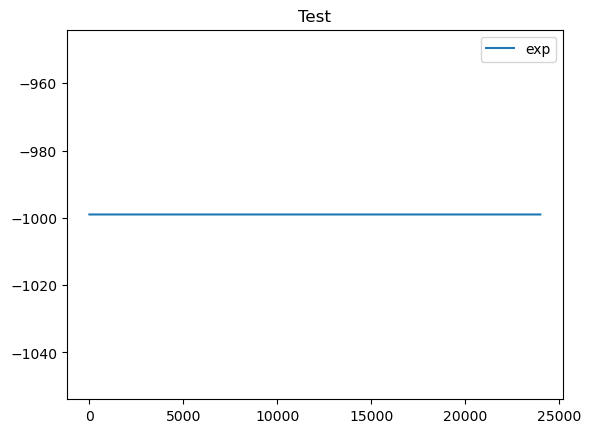

In [72]:
print('Test RMSE ard: %.3f' % np.sqrt(mean_squared_error(Y_zug, predictions_zug_ard)))
print('Test RMSE bay: %.3f' % np.sqrt(mean_squared_error(Y_zug, predictions_zug_bay)))
print('Test RMSE mlp: %.3f' % np.sqrt(mean_squared_error(Y_zug, predictions_zug_mlp)))

fig, ax = plt.subplots()
#ax.plot(predictions_zug_ard,label="ard")
#ax.plot(predictions_zug_bay,label="bay")
#ax.plot(predictions_zug_mlp,label="mlp")
#ax.plot(predictions_zug_lstm,label="lstm")
ax.plot(Y_zug,label='exp')
ax.legend()
plt.title('Test')
plt.show()